1. ### IMPORT NECESSARY LIBRARIES

In [1]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

2. ### SET DEVICE

In [3]:
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

3. ### GET DATASETS

In [5]:

from torchvision import datasets, transforms

In [4]:
# Define the transformation to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

In [33]:
# Load the MNIST dataset with the specified transformation
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [32]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

4. ### SPLIT MNIST DATASET

In [34]:
#Split data into train and validation dataset
torch.manual_seed(44)
train_size = int(0.8 * len(train_dataset)) 
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])



In [46]:
#Create Dataloaders
torch.manual_seed(44)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)


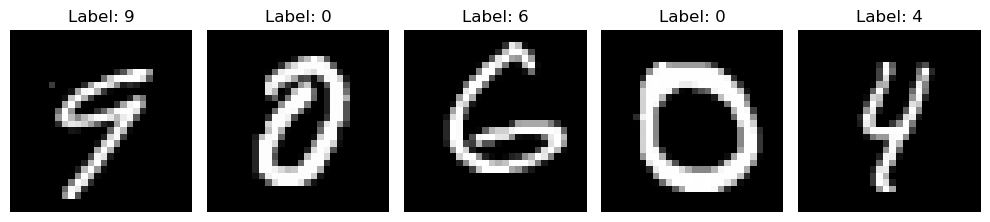

In [57]:
#Plot sample images
torch.manual_seed(44)
# Create a figure to display the images
plt.figure(figsize=(10, 3))

# Print the first few images in a row
for i, (image, label) in enumerate(train_loader):
    if i < 5:  # Print the first 5 samples
        plt.subplot(1, 5, i + 1)
        plt.imshow(image[0].squeeze(), cmap='gray')
        plt.title(f"Label: {label.item()}")
        plt.axis('off')
    else:
        break  # Exit the loop after printing 5 samples

plt.tight_layout()
plt.show()
  



In [52]:
len(train_dataset), len(val_dataset), len(test_dataset)

(48000, 12000, 10000)

In [50]:
#Check dataset sample
#Check the dataset sample
image, label = train_dataset[2]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [59]:
image.shape

torch.Size([1, 1, 28, 28])

5. ### PREPARE DATALOADERS FOR TRAINING

In [ ]:
#Prepare DataLoader
from torch.utils.data import DataLoader

#Set Batch size
BATCH_SIZE = 64

#Turn datasets into iterables
training_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False )
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


#Lets check what we have created

print(f"Length of train_dataloader {len(training_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of validation_dataloader {len(validation_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader {len(test_dataloader)} batches of size {BATCH_SIZE}")

Length of train_dataloader 750 batches of size 64
Length of train_dataloader 188 batches of size 64
Length of test_dataloader 157 batches of size 64


 6. ### CLASSIFICATION MODEL

In [64]:
import torch.nn as nn
import torchvision
import torchvision.models as models

In [78]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define custom DenseNet-121 model for 28x28 images
class DenseNet121_28x28(nn.Module):
    def __init__(self, num_classes=10, bias=True, dropout=0.2):
        super(DenseNet121_28x28, self).__init__()
        self.model = models.densenet121(weights=None)  # Use weights="DEFAULT" for pretrained
        self.model.features.conv0 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=bias)
        
        # Custom classifier with dropout and hidden layer
        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 512, bias=bias),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes, bias=bias)
        )

    def forward(self, x):
        return self.model(x)



In [79]:
# Create an instance of the model
model = DenseNet121_28x28(num_classes=10, bias=True, dropout=0.2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model architecture (optional)
print(model)


DenseNet121_28x28(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

7. ### TRAINING LOOP

In [83]:
# Ensure dataset loading and model instantiation are done before this code

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Move the existing model to the correct device
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop (datasets should be loaded before this)
torch.manual_seed(44)
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")  # Print epoch number
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(training_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress for every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(training_dataloader)} - Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(training_dataloader)  # Correct loss averaging
    print(f"  Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}")

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"  Validation Accuracy: {accuracy:.4f}")

print("\nTraining Complete!")



Epoch [1/10]
  Batch 10/750 - Loss: 0.1569
  Batch 20/750 - Loss: 0.3049
  Batch 30/750 - Loss: 0.1177
  Batch 40/750 - Loss: 0.2660
  Batch 50/750 - Loss: 0.0188
  Batch 60/750 - Loss: 0.4133
  Batch 70/750 - Loss: 0.0898
  Batch 80/750 - Loss: 0.0258
  Batch 90/750 - Loss: 0.1345
  Batch 100/750 - Loss: 0.0911
  Batch 110/750 - Loss: 0.0151
  Batch 120/750 - Loss: 0.1174
  Batch 130/750 - Loss: 0.1744
  Batch 140/750 - Loss: 0.0739
  Batch 150/750 - Loss: 0.0317
  Batch 160/750 - Loss: 0.0495
  Batch 170/750 - Loss: 0.0434
  Batch 180/750 - Loss: 0.0214
  Batch 190/750 - Loss: 0.1703
  Batch 200/750 - Loss: 0.0171
  Batch 210/750 - Loss: 0.1284
  Batch 220/750 - Loss: 0.1125
  Batch 230/750 - Loss: 0.0291
  Batch 240/750 - Loss: 0.0308
  Batch 250/750 - Loss: 0.0274
  Batch 260/750 - Loss: 0.1027
  Batch 270/750 - Loss: 0.0427
  Batch 280/750 - Loss: 0.0821
  Batch 290/750 - Loss: 0.0107
  Batch 300/750 - Loss: 0.0268
  Batch 310/750 - Loss: 0.0867
  Batch 320/750 - Loss: 0.0139
  B

8. ### EVALUATE MODEL

In [84]:
#Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        
        print(f"Test Accuracy : {accuracy:.4f}")
        

Test Accuracy : 1.0000
Test Accuracy : 0.9922
Test Accuracy : 0.9948
Test Accuracy : 0.9922
Test Accuracy : 0.9938
Test Accuracy : 0.9896
Test Accuracy : 0.9866
Test Accuracy : 0.9883
Test Accuracy : 0.9878
Test Accuracy : 0.9875
Test Accuracy : 0.9872
Test Accuracy : 0.9883
Test Accuracy : 0.9892
Test Accuracy : 0.9900
Test Accuracy : 0.9875
Test Accuracy : 0.9873
Test Accuracy : 0.9871
Test Accuracy : 0.9870
Test Accuracy : 0.9877
Test Accuracy : 0.9859
Test Accuracy : 0.9866
Test Accuracy : 0.9865
Test Accuracy : 0.9871
Test Accuracy : 0.9876
Test Accuracy : 0.9881
Test Accuracy : 0.9886
Test Accuracy : 0.9890
Test Accuracy : 0.9883
Test Accuracy : 0.9887
Test Accuracy : 0.9880
Test Accuracy : 0.9884
Test Accuracy : 0.9883
Test Accuracy : 0.9882
Test Accuracy : 0.9876
Test Accuracy : 0.9879
Test Accuracy : 0.9883
Test Accuracy : 0.9882
Test Accuracy : 0.9885
Test Accuracy : 0.9880
Test Accuracy : 0.9879
Test Accuracy : 0.9878
Test Accuracy : 0.9877
Test Accuracy : 0.9880
Test Accura

In [86]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Test Loss: %.3f, Test Accuracy: %.3f' % (test_loss / len(test_dataloader), accuracy))

Test Loss: 0.032, Test Accuracy: 0.992


## A. RESULTS ANALYSIS
#### The test loass of 0.032 and Test accuracy of 0.992 (99.2%) shows that the DenseNET-121 model adjusted with parameters
#### trained for 10 epochs at a learning rate of 0.01 in batches of 64 since the training was cpu bound. With GPU training can be faster
#### size can be set to 128 with samme epochs and maybe training can be less that 7 hours. The DenseNet -121 is one of the best models
#### for the MNIST dataset and model can be leveraged for datasets with the same characteristics for deployment.

In [95]:
#Set model to evaluation mode
model.eval()

#Initialise lists to store predictions and labels
predictions = []
labels = []
results = []
#Iterate over the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        inputs, batch_labels = batch
        inputs, batch_labels = inputs.to(device),batch_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(batch_labels.cpu().tolist())
    for i in range(len(batch_labels)):
        result = {'Truth Label': batch_labels[i].cpu().item(),'Predicted Label': predicted[i].cpu().tolist()}
        results.append(result)

In [96]:
#Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels, predictions)
print(conf_mat)
for resullts in results:
    print(result)

[[ 973    0    2    0    0    1    2    2    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    1 1029    0    0    0    0    2    0    0]
 [   0    0    0 1007    0    2    0    0    0    1]
 [   0    0    2    0  960    0    2    0    1   17]
 [   0    1    0    5    0  884    1    0    0    1]
 [   4    3    0    0    0    4  947    0    0    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [   0    0    4    2    0    3    0    1  962    2]
 [   1    1    0    1    1    3    0    2    0 1000]]
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6, 'Predicted Label': 6}
{'Truth Label': 6,

In [97]:
#Save the model
torch.save(model.state_dict(), 'mnist_model.pth')